# redundant calibration

Nick Kern
<br>
May, 2022

See Dillon et al. 2018 and Dillon et al. 2021 for notes on the degeneracies associated with redundant calibration (1. average amplitude and 2. East-West phase gradient i.e. tip-tilt gradient). See Kern et al. 2020 for an example of how these degenerate terms are calibrated and added to the redcal solutions to make the full redcal-abscal gains.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy import stats

from pyuvdata import UVData, UVBeam
import linsolve
import hera_cal as hc

from collections import OrderedDict as odict
from hera_cal.abscal import fill_dict_nans
import pyuvdata

In [4]:
filter_type="dpss_25"
mode="low"

In [5]:
hd = hc.io.HERAData("/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Raw_data_filtered_Gaussian_non_redundant_with_noise_"+mode+"_2h.uvh5")
freqs = hd.freq_array[0,1:204]
time=np.unique(hd.time_array)[0]

# load the metadata
hd_unfil = hc.io.HERAData('/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Raw_data_non_redundant_with_noise_'+mode+'_2h.uvh5')
hd_unfil_model = hc.io.HERAData('/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Model_first_order_visibilities_2h_boosted_'+mode+'.uvh5')
hd2 = hc.io.HERAData("/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Model_complete_filtered_Gaussian_non_redundant_"+mode+"_2h.uvh5")


In [6]:
lsts = np.unwrap(hd.lsts) * 12/np.pi - 24
time=np.unique(hd.time_array)[0]

In [7]:

# only load a couple of times and frequencies
time=np.unique(hd.time_array)[50]
pol=hd.polarization_array
hd.read(polarizations=pol[0],frequencies=freqs,times=time)
hd2.read(polarizations=pol[0],frequencies=freqs,times=time)
hd_unfil.read(polarizations=pol[0],frequencies=freqs,times=time)
hd_unfil_model.read(polarizations=pol[0],frequencies=freqs,times=time)

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994855608 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994858716 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994857206 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994858716 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


(<hera_cal.datacontainer.DataContainer at 0x7f2c39d84650>,
 <hera_cal.datacontainer.DataContainer at 0x7f2c15f2e150>)

In [8]:
# inflate by full redundancy
reduncy_xtalk=False
if reduncy_xtalk:
    hd.inflate_by_redundancy()
hd.conjugate_bls()
hd._determine_blt_slicing()
hd._determine_pol_indexing()

In [9]:
hd_unfil_model.conjugate_bls()
hd_unfil_model._determine_blt_slicing()
hd_unfil_model._determine_pol_indexing()

In [10]:
# hd2.inflate_by_redundancy()
hd2.conjugate_bls()
hd2._determine_blt_slicing()
hd2._determine_pol_indexing()

Text(0, 0.5, 'Y distance [m]')

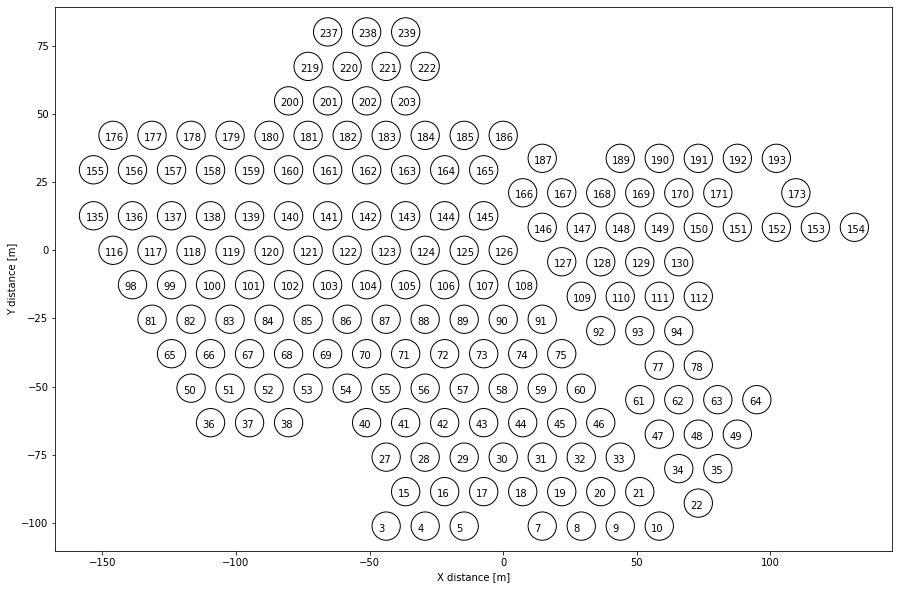

In [11]:
antpos, ants = hd.get_ENU_antpos(pick_data_ants=True)
antpos_d = dict(zip(ants, antpos))
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(antpos[:, 0], antpos[:, 1], fc='none', ec='k', s=800)
for i, ant in enumerate(ants):
    plt.text(antpos[i,0]-3, antpos[i,1]-2, ant, fontsize=10)
plt.xlabel("X distance [m]")   
plt.ylabel("Y distance [m]")   

In [12]:
baseline_match_array=np.load("/home/ntsikelelo/Simulated_data_files/matched_baselines.npy")
bls_match=[]
for i in range (len(baseline_match_array)):
    key=baseline_match_array[i,:]
    bls_match.append((key[0],key[1]))

In [13]:
hd.select(bls=bls_match)
hd2.select(bls=bls_match)
hd_unfil.select(bls=bls_match)
hd_unfil_model.select(bls=bls_match)


hd.x_orientation = 'east'
hd2.x_orientation = 'east'
hd_unfil.x_orientation='east'
hd_unfil_model.x_orientation='east'

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994855608 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994858716 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994857206 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994858716 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


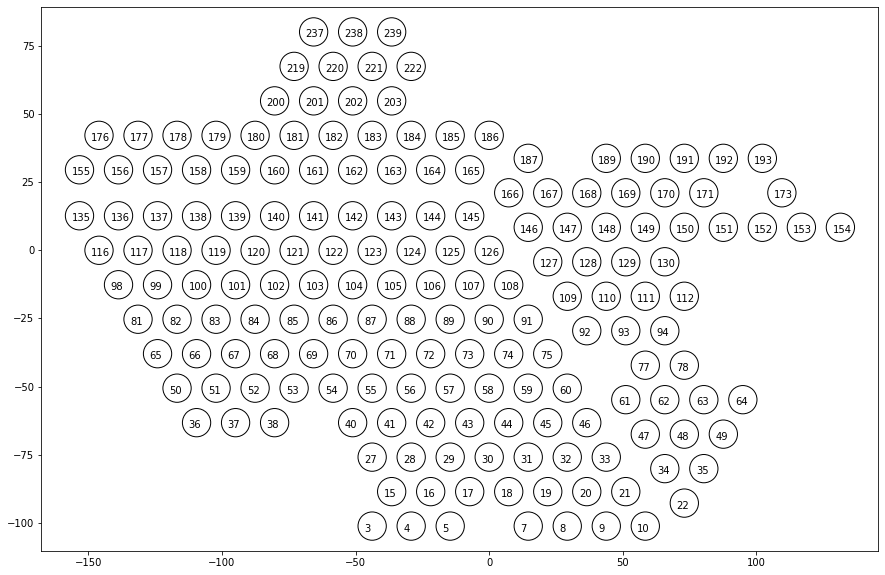

In [14]:
antpos, ants = hd.get_ENU_antpos(pick_data_ants=True)
antpos_d = dict(zip(ants, antpos))
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(antpos[:, 0], antpos[:, 1], fc='none', ec='k', s=800)
for i, ant in enumerate(ants):
    plt.text(antpos[i,0]-3, antpos[i,1]-2, ant, fontsize=10)

In [15]:
# load datacontainer
data, _, _ = hd.build_datacontainers() # x-talk
data_un, _, _ = hd_unfil.build_datacontainers() # x-talk
model_un, _, _ = hd_unfil_model.build_datacontainers() # x-talk
model, _, _ = hd2.build_datacontainers() #sky model 
Ntimes, Nfreqs = hd.Ntimes, hd.Nfreqs
freqs = hd.freq_array[0]/1e6

In [30]:
# get redundant baseline groups
reds = hc.redcal.get_reds(antpos_d, pols=['ee'])



In [17]:
# get redundant baseline groups
reds = hc.redcal.get_reds(antpos_d, pols=['ee'])
red_data=[]
for red_g in reds:
    bl_group=[]
    for bl in red_g:
        if bl in list(model.keys()):
            bl_group.append(bl)    
    if len(bl_group)>0:   
        red_data.append(bl_group)    

In [18]:
#filter redundant baselines
# filtered_reds = hc.redcal.filter_reds(reds, max_dims=2, bls=data.keys())

# rc = hc.redcal.RedundantCalibrator(filtered_reds)
rc = hc.redcal.RedundantCalibrator(red_data)

# perform redcal-logcal and redcal-lincal (aka omnical)

In [19]:
# get noise wgts (use whatever noise RMS you put into the data)
Nrms = 1e-4
noise_wgts = {k: np.ones_like(data[k], dtype=float) / Nrms**2 for k in data}
cut=0
for k in data:

    blvec = (antpos[np.where(ants==k[0])][0] - antpos[np.where(ants==k[1])][0])

    bl_len_EW = np.abs(blvec[0])

    if bl_len_EW <30: 
        cut+=1

        noise_wgts[k] = np.ones(noise_wgts[k].shape)*1e-40

In [20]:
%%time
# perform logcal
logcal_meta, logcal_sol = rc.logcal(data)
hc.redcal.make_sol_finite(logcal_sol)
# remove redcal degeneracies from solution
logcal_sol = rc.remove_degen(logcal_sol)
# get gains and model visibilities
logcal_gains, logcal_vis = hc.redcal.get_gains_and_vis_from_sol(logcal_sol)

CPU times: user 9.91 s, sys: 3.59 s, total: 13.5 s
Wall time: 6.49 s


In [21]:
%%time
# perform logcal
logcal_meta, logcal_sol = rc.logcal(data)
hc.redcal.make_sol_finite(logcal_sol)
# remove redcal degeneracies from solution
logcal_sol = rc.remove_degen(logcal_sol)
# get gains and model visibilities
logcal_gains, logcal_vis = hc.redcal.get_gains_and_vis_from_sol(logcal_sol)

CPU times: user 10.8 s, sys: 3.9 s, total: 14.7 s
Wall time: 6.47 s


In [22]:
%%time
# perform omnical (lincal)
conv_crit = 1e-10
maxiter = 500
gain = 0.4
lincal_meta, lincal_sol = rc.omnical(data, logcal_sol, wgts=noise_wgts, conv_crit=conv_crit,
                                 maxiter=maxiter, gain=gain)
hc.redcal.make_sol_finite(lincal_sol)
# remove redcal degeneracies from solution
lincal_sol = rc.remove_degen(lincal_sol)
# get gains and model visibilities
lincal_gains, lincal_vis = hc.redcal.get_gains_and_vis_from_sol(lincal_sol)

CPU times: user 1min 34s, sys: 304 ms, total: 1min 35s
Wall time: 1min 35s


In [23]:
len(logcal_sol.keys()), len(data.keys())
# np.save("lincal_30_m.npy",lincal_gains[(3,'Jee')][0,:])
g1=np.load("lincal_30_m.npy")
g2=np.load("lincal_no_filter.npy")
g3=np.load("lincal_no_filter_50_m.npy")
g4=np.load("lincal_no_filter_50_m_smaller.npy")

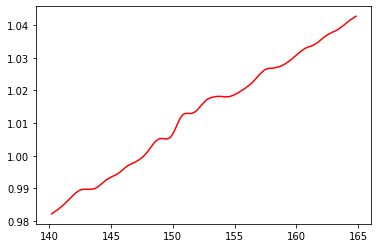

In [24]:
plt.plot(freqs,np.mean(np.abs(lincal_gains[(5,'Jee')]),axis=0),'r')
# plt.plot(freqs,np.abs(g1),'g')
# plt.plot(freqs,np.abs(g2),'k')
# plt.plot(freqs,np.abs(g3),'b')
# plt.plot(freqs,np.abs(g4),'g')
# plt.xlabel('freq [MHz]')
# plt.ylabel('|g|')
# plt.figure()
# # plt.plot(freqs,np.angle(lincal_gains[(3,'Jee')][0,:]),'r',label="100m bc")
# plt.plot(freqs,np.angle(g4),'g',label="bc > 50 m")
# plt.plot(freqs,np.angle(g2),'k',label="no bc")
# plt.plot(freqs,np.angle(g3),'b',label="bc < 50 m")
# plt.xlabel('freq [MHz]')
# plt.ylabel('phase of g [rad]')
# plt.legend()

In [25]:
# # get a list of antennas
# ants = sorted(set(np.ravel([k[:2] for k in model.keys()])))
N_t=len(np.unique(hd.time_array))
gains_all=np.zeros(shape=(len(ants),N_t,len(freqs)),dtype=complex)
ant=0
for key in lincal_gains:
    gains_per_ant=lincal_gains[key]
    
    for t in range (N_t):
        gains_all[ant,t,:]=gains_per_ant[t,:]
        
    ant=ant+1



In [26]:
from scipy import signal
g0=gains_all

Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N_t):
    
        window[ant,t,:] = signal.blackmanharris(len(freqs))

gain_original_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
#gain_original_delay2=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]




(0.0, 3000.0)

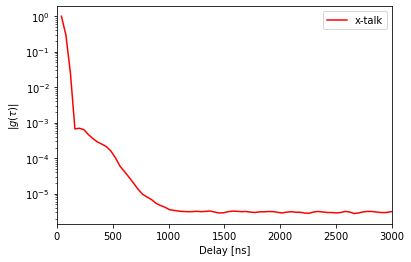

In [27]:

plt.semilogy(tau_pos,gain_original_delay/np.max(gain_original_delay),'r',label="x-talk")
# plt.semilogy(tau_pos,gain_original_delay2/np.max(gain_original_delay2),label="zeroth")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,3000)

In [28]:
# compute chisq
Nrms = 1e-4
sigma_frac=np.load('/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/sigma_frac_60.npy')
noise_wgts = {k: np.ones_like(data[k], dtype=float) / (sigma_frac*Nrms)**2 for k in data}

rc_red_chisq, chisq_per_ant = hc.redcal.normalized_chisq(data, noise_wgts, red_data, lincal_vis, lincal_gains)
rc_red_chisq_dof = len(data) - len(lincal_gains)
rc_red_chisq = rc_red_chisq['Jee']


noise_wgts = {k: np.ones_like(data[k], dtype=float) / (Nrms)**2 for k in data}

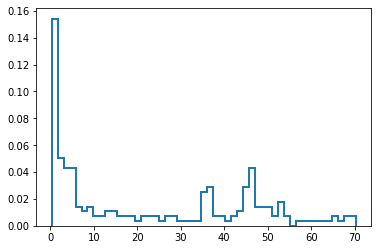

In [29]:

plt.hist(rc_red_chisq.ravel(), bins=51, density=True, histtype='step', lw=2);

# absolute calibration

Use a sky model to compute the degenerate modes of redcal

In [30]:
# get a list of antennas
ants_mod = sorted(set(np.ravel([k[:2] for k in model.keys()])))

np.random.seed(0)
Nants = len(ants_mod)
amps = np.random.normal(0.03, 0.001, Nants) # amp
#phs = np.random.normal(0, np.pi/4, Nants) # radians
dly =0*np.random.normal(0, 200, Nants) * 1e-9 # in seconds
amp_plaw = np.random.normal(-2.6, 0.2, Nants)
gains = amps * (freqs[:, None] / 150)**amp_plaw * np.exp(1j * 2 * np.pi * dly * freqs[:, None]*1e6)
phase_gains=np.zeros(gains.shape,dtype=complex)
for ant in range(Nants):
    k_a,k_b = np.random.normal(0.0005, 0.0005, 2)
    phs=np.cos(k_a*freqs)+np.sin(k_b*freqs)
    phase_gains[:,ant]=np.exp(1j * phs)
gains*=phase_gains 

gains_init = {(ant, 'Jee'): gains[:, i][None, :] for i, ant in enumerate(ants)}
full_gains = hc.abscal.merge_gains([gains_init])#, gains_resid])

# set reference antenna
ref_ant = (127, 'Jee')
hc.abscal.rephase_to_refant(full_gains, refant=ref_ant)

In [31]:
noise_wgts = {k: np.ones_like(data[k], dtype=float) / Nrms**2 for k in data}
cut=0
for k in data:

    blvec = (antpos[np.where(ants==k[0])][0] - antpos[np.where(ants==k[1])][0])

    bl_len_EW = np.abs(blvec[0])

    if bl_len_EW <30: 
        cut+=1

        noise_wgts[k] = np.ones(noise_wgts[k].shape)*1e-40

In [32]:
# calibration with lincal gains
redcal_data = copy.deepcopy(data)
hc.apply_cal.calibrate_in_place(redcal_data, lincal_gains)
rc_flags = {k: np.zeros_like(full_gains[k], dtype=bool) for k in full_gains}

In [33]:
abscal_gains = hc.abscal.post_redcal_abscal(model, redcal_data, noise_wgts, rc_flags, verbose=False)

# compare redcal-abscal gains with starting gains

In [34]:
# combine redcal and abscal gains
total_gains = hc.abscal.merge_gains([lincal_gains, abscal_gains])
# make sure it has the same reference antenna
# set reference antenna
ref_ant = (127, 'Jee')
hc.abscal.rephase_to_refant(total_gains, ref_ant)

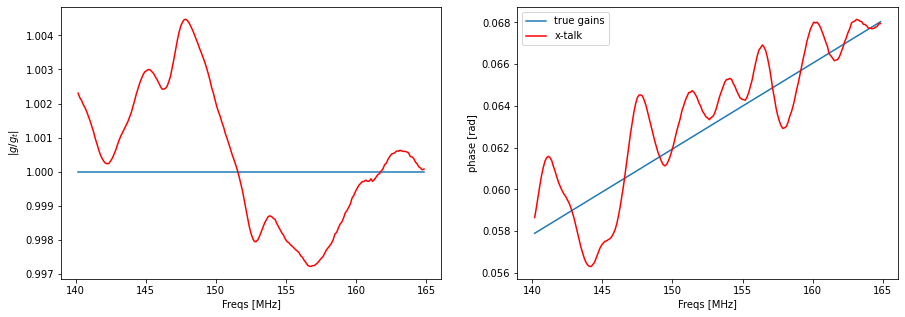

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
k = (74, 'Jee')

ax = axes[0]
# plot ampltiude ratio
ax.plot(freqs, np.abs(full_gains[k] )[0]/np.abs(full_gains[k] )[0])
ax.plot(freqs, np.abs(total_gains[k] )[0]/np.abs(full_gains[k] )[0],'r')
ax.set_xlabel("Freqs [MHz]")
ax.set_ylabel("$|g/g_t|$")

ax = axes[1]
# plot phase ratio
ax.plot(freqs, np.angle(full_gains[k])[0],label='true gains')
ax.plot(freqs, np.angle(total_gains[k] )[0],'r',label='x-talk')
ax.set_xlabel("Freqs [MHz]")
ax.set_ylabel("phase [rad]")
ax.legend()

In [36]:
gains_all=np.zeros(shape=(len(ants),N_t,len(freqs)),dtype=complex)
ant=0
for key in total_gains:
    gains_per_ant=total_gains[key]
    for t in range (N_t):
        gains_all[ant,t,:]=gains_per_ant[t,:]
    ant=ant+1 
       

In [37]:
from scipy import signal
g0=gains_all

Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N_t):
    
        window[ant,t,:] = signal.blackmanharris(len(freqs))

gain_original_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]



(0.0, 1500.0)

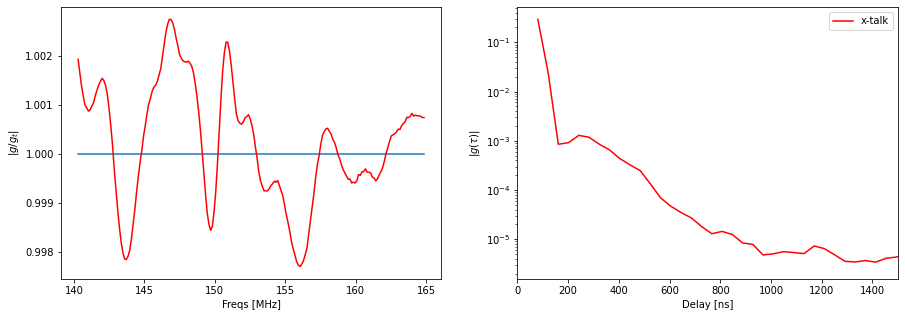

In [38]:
k = (3, 'Jee')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax = axes[0]
# plot ampltiude ratio
ax.plot(freqs[1:204], np.abs(total_gains[k] )[0][1:204]/np.abs(total_gains[k])[0][1:204])
ax.plot(freqs[1:204], np.abs(total_gains[k] )[0][1:204]/np.abs(full_gains[k] )[0][1:204],'r')
ax.set_xlabel("Freqs [MHz]")
ax.set_ylabel("$|g/g_t|$")

ax=axes[1]
ax.semilogy(tau_pos[1:204],gain_original_delay[1:204]/np.max(gain_original_delay),'r',label="x-talk")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,1500)

In [39]:

# get chisq after redcal and abscal
Nrms = 1e-4
sigma_frac=np.load('/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/sigma_frac_60.npy')
noise_wgts = {k: np.ones_like(data[k], dtype=float) / (sigma_frac*Nrms)**2 for k in data}

abs_chisq, nObs, _, _ = hc.utils.chisq(data, model, gains=total_gains, data_wgts=noise_wgts)
chisq_dof = nObs.mean() - len(abscal_gains)
red_chisq = abs_chisq / chisq_dof

invalid value encountered in true_divide


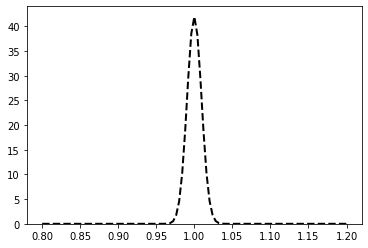

In [40]:
x = np.linspace(0.8, 1.2, 101)
plt.plot(x, stats.chi2.pdf(x * 2*chisq_dof, 2*chisq_dof) * 2*chisq_dof, c='k', ls='--', lw=2, label='ideal')
plt.hist(red_chisq.ravel(), bins=51, range=(0.8, 1.2), density=True, histtype='step', lw=2);

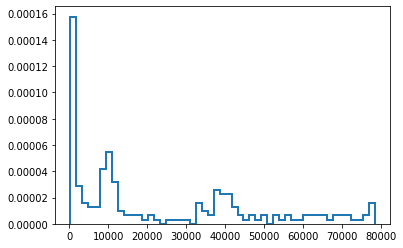

In [41]:
plt.hist(red_chisq.ravel(), bins=51, density=True, histtype='step', lw=2);

In [42]:
# calibrate data
cal_data = copy.deepcopy(data_un)
hc.apply_cal.calibrate_in_place(cal_data, total_gains)

In [43]:
# # get redundant groups
antpos, ants = hd.get_ENU_antpos()
antpos_dict = dict(zip(ants, antpos))
# reds = hc.redcal.get_pos_reds(antpos_dict)

In [44]:
bl_lens, bl_groups = [], []
for red in red_data:
    # get the baseline length of this redundant group
    bl = red[0]
    bl_len = np.linalg.norm(antpos_dict[bl[1]] - antpos_dict[bl[0]])
    # check if this bl_len exists
    if np.isclose(bl_len, bl_lens, atol=1).any():
        bl_groups[-1].extend(red)
    else:
        bl_groups.append(red)
        bl_lens.append(bl_len)


# now average all baselines within each group
N_t=len(np.unique(hd.time_array))
cal_wedge = np.zeros((N_t,len(bl_groups), hd.Nfreqs, hd.Npols), dtype=np.complex128)
mdl_wedge = np.zeros((N_t,len(bl_groups), hd.Nfreqs, hd.Npols), dtype=np.complex128)

for i, bl_group in enumerate(bl_groups):
    for j, pol in enumerate(hd.get_pols()):
        cal_wedge[:,i, :, j] = np.mean([cal_data[bl] for bl in bl_group], axis=0)
        mdl_wedge[:,i, :, j] = np.mean([model_un[bl] for bl in bl_group], axis=0)


# now take the FFT across frequency: cut the edge channels
cal_wedge_fft, delays = hc.vis_clean.fft_data(cal_wedge, np.diff(freqs)[0], axis=2,
                                              edgecut_low=5, edgecut_hi=5, window='bh')
mdl_wedge_fft, delays = hc.vis_clean.fft_data(mdl_wedge, np.diff(freqs)[0], axis=2,
                                              edgecut_low=5, edgecut_hi=5, window='bh')

print(cal_wedge_fft.shape)

     

(1, 59, 203, 1)


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


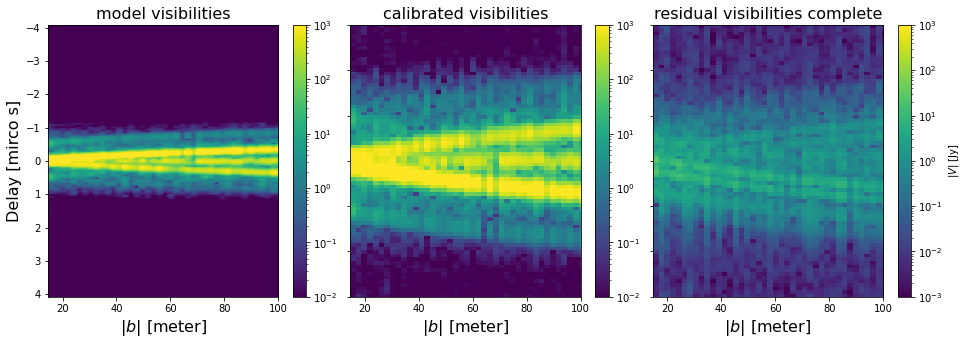

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)
import matplotlib
ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [mirco s]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
# ax.set_ylim(-1.500, 1.500)
ax.set_xlim(bl_lens[0], 100)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_xlim(bl_lens[0], 100)
ax.set_ylim(-1.500, 1.500)
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-3, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities complete", fontsize=16)
ax.set_xlim(bl_lens[0], 100)
ax.set_ylim(-1.500, 1.500)
ax.set_yticklabels([])
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
# plt.plot(base_line,wedge_line,'w')
# plt.plot(base_line,wedge_line_,'w')
